Gerekli kutuphanler

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

Verisetini okuma

In [2]:
label = []
path = []
dir = '/kaggle/input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset'

# Gather image paths and labels
for dir_path, _, filenames in os.walk(dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if dir_path.split()[-1] != 'GT':
                label.append(os.path.split(dir_path)[-1])
                path.append(os.path.join(dir_path, filename))

Bazi ornek goruntulerin gorsellestirilmesi

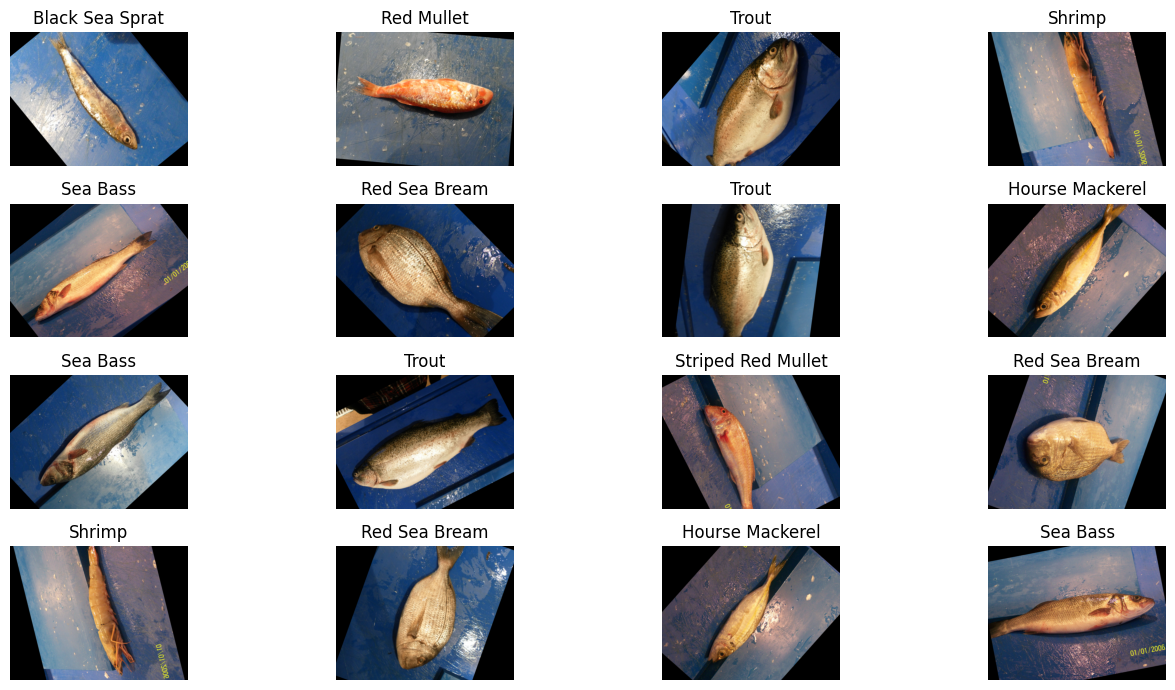

In [3]:
data = pd.DataFrame({'path': path, 'label': label})


plt.figure(figsize=(14,7))
IMG_NUM = len(path)
for i in range(16):
    rand_num = np.random.randint(0, IMG_NUM)
    plt.subplot(4, 4, i+1)
    plt.title(label[rand_num])
    current_img = plt.imread(path[rand_num])
    plt.imshow(current_img)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [4]:
data.head()

,path,label
0,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
1,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
2,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
3,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel
4,/kaggle/input/a-large-scale-fish-dataset/Fish_...,Hourse Mackerel


In [5]:
data.info

<bound method DataFrame.info of                                                    path            label
0     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
1     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
2     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
3     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
4     /kaggle/input/a-large-scale-fish-dataset/Fish_...  Hourse Mackerel
...                                                 ...              ...
8995  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8996  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8997  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8998  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream
8999  /kaggle/input/a-large-scale-fish-dataset/Fish_...    Red Sea Bream

[9000 rows x 2 columns]>

egitim, test ve validasyon verisine bolunme

In [6]:
x_train, x_temp = train_test_split(data, test_size=0.2, random_state=42)
x_val, x_test = train_test_split(x_temp, test_size=0.8, random_state=42)

görüntüleri 0-1 aralığına normalize etme

In [7]:
img_datagen = ImageDataGenerator(rescale=1./255)

görüntü verileri üzerinde çeşitli artırma teknikleri uygulayarak modelin genelleme yeteneğini artırma. Görüntüleri döndürme, kaydırma, yakınlaştırma, yatay çevirme gibi işlemler, eğitim sırasında modelin daha çeşitli veri ile karşılaşmasını sağlayarak aşırı öğrenmeyi önler ve genel performansı artırır. 

In [8]:
img_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

Görüntü dosyalarının yolları ve etiketleri kullanılarak veri kümesi oluşturma ve her bir görüntü, belirtilen boyutlara yeniden boyutlandırılarak modele uygun hale getirme.

In [9]:
x_train = img_datagen.flow_from_dataframe(
    dataframe=x_train,
    x_col ='path',
    y_col = 'label',
    class_mode='categorical',
    target_size = (224,224),
    seed=42
)
x_test = img_datagen.flow_from_dataframe(
    dataframe=x_test,
    x_col ='path',
    y_col = 'label',
    target_size = (224,224),
    seed=42,
    class_mode='categorical',
    shuffle=False
)
x_val = img_datagen.flow_from_dataframe(
    dataframe=x_val,
    x_col ='path',
    y_col = 'label',
    target_size = (224,224),
    class_mode='categorical',
    seed=42
)

Found 7200 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.
Found 360 validated image filenames belonging to 9 classes.


temel bir model. Modelin son katmanları dahil edilmez. Temel modelin ağırlıkları dondurularak, sadece üst katmanlar eğitilecektir.

In [10]:
from tensorflow.keras.applications import MobileNetV2


base_model = MobileNetV2(weights="imagenet", include_top=False, input_shape=((224,224) + (3,)))
base_model.trainable = False

"""
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(9, activation="softmax")  # Sınıf sayısını ayarlayın
])
"""

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


'\nmodel = tf.keras.Sequential([\n    base_model,\n    tf.keras.layers.GlobalAveragePooling2D(),\n    tf.keras.layers.Dense(128, activation="relu"),\n    tf.keras.layers.Dropout(0.4),\n    tf.keras.layers.Dense(64, activation="relu"),\n    tf.keras.layers.Dropout(0.4),\n    tf.keras.layers.Dense(9, activation="softmax")  # Sınıf sayısını ayarlayın\n])\n'

Özellik çıkarımi birkaç tam bağlantılı katman, dropout ve L2 düzenlemesi. Model, 9 farklı balik sınıfı tahmini icin. Aşırı öğrenmeyi önlemek ve modelin genelleme yeteneğini artırmak amacıyla düzenleme teknikleri içerir.

In [11]:
from tensorflow.keras.regularizers import l2

model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),  # Dropout oranını artırın
    tf.keras.layers.Dense(64, activation="relu", kernel_regularizer=l2(0.01)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(9, activation="softmax")
])



model compile

In [12]:

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001),
    loss = "categorical_crossentropy",
    metrics=["accuracy"]
)

derin öğrenme modelini derlemek için. Adam optimizasyon algoritması ve categorical crossentropy kayıp fonksiyonu ile modelin eğitimi için gereken parametreler. Doğruluk metriği, modelin performansını değerlendirmek için.

In [13]:

train = model.fit(
    x_train,
    epochs=10,
    validation_data=x_val,
    
)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729802418.809728      71 service.cc:145] XLA service 0x79ee3c003a40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729802418.809805      71 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729802418.809812      71 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


  1/225 ━━━━━━━━━━━━━━━━━━━━ 1:20:15 21s/step - accuracy: 0.1562 - loss: 6.1285

I0000 00:00:1729802428.110535      71 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


225/225 ━━━━━━━━━━━━━━━━━━━━ 210s 841ms/step - accuracy: 0.3871 - loss: 3.9675 - val_accuracy: 0.9750 - val_loss: 1.1054
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 614ms/step - accuracy: 0.8510 - loss: 1.2486 - val_accuracy: 0.9917 - val_loss: 0.5965
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 143s 616ms/step - accuracy: 0.9061 - loss: 0.7838 - val_accuracy: 0.9917 - val_loss: 0.4376
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 611ms/step - accuracy: 0.9167 - loss: 0.6354 - val_accuracy: 0.9861 - val_loss: 0.3789
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 612ms/step - accuracy: 0.9378 - loss: 0.5439 - val_accuracy: 0.9889 - val_loss: 0.3486
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 141s 610ms/step - accuracy: 0.9274 - loss: 0.5240 - val_accuracy: 0.9972 - val_loss: 0.3029
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 612ms/step - accuracy: 0.9409 - loss: 0.4815 - val_accuracy: 0.9861 - val_loss: 0.3228
Epoch 8/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 142s 612ms/step - accuracy: 0.9438 - loss: 0.45

gorsellestirme

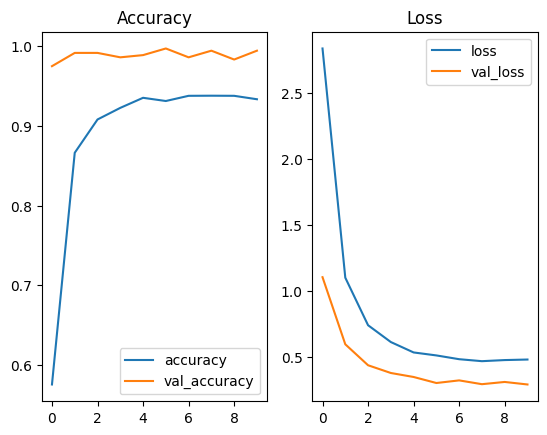

In [14]:
plt.subplot(1, 2, 1)
pd.DataFrame(train.history)[['accuracy', 'val_accuracy']].plot(ax=plt.gca())
plt.title("Accuracy")

plt.subplot(1, 2, 2)
pd.DataFrame(train.history)[['loss', 'val_loss']].plot(ax=plt.gca())
plt.title("Loss")
plt.show()

test verisi üzerindeki kayıp ve doğruluk değerleri

In [15]:

result = model.evaluate(x_test, verbose=0)
print("Test Loss:", result[0])
print("Test Accuracy:", result[1] * 100)

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 0.30724194645881653
Test Accuracy: 98.8194465637207
